# Resources 
## Links 
* https://www.kaggle.com/code/satyaprakashshukl/mushroom-classification-analysis/notebook
* https://www.kaggle.com/code/ambrosm/pss4e8-eda-which-makes-sense#First-observations 
* https://www.kaggle.com/code/annastasy/ps4e8-data-cleaning-and-eda-of-mushrooms

## Code Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

2024-08-22 18:36:46.577562: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-22 18:36:46.577688: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-22 18:36:46.720884: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 1. Problem Definition
## 1.1 Scenario

Welcome back! Today, our client has given us the task of binary classification of mushrooms. The client lives far out in a magical forest and needs an application to help her identify which mushrooms she can eat and which she cannot. Luckily for us, she brought with her an ancient tome of mushroom classification. There is some information missing though, so we will have to work around that. She is hoping that we can come up with a model, so she does not have to flip through every page of this massive book. Oh, and she's hoping that your model will not get her sick either! 

## 1.2 Scoring Metric
For our client, we will be using the Matthews correlation coefficient (MCC). What does this mean? The MCC is a scoring equation that is calculated using true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN). For you nerds, here is the full equation. 

$$
\text{MCC} = \frac{(TP \times TN) - (FP \times FN)}{\sqrt{(TP + FP) \times (TP + FN) \times (TN + FP) \times (TN + FN)}}
$$

The MCC is great for binary classification, especially where datasets are imbalanced in favor of one type of classification. The last thing to know is that this equation will give us a score from -1 to 1, where -1 is total misclassification, 0 is no predictive power (randomly guessing), and 1 is a perfect classification. 

# 2. Data Collection and Analysis
## 2.1 Import Data and Look at Raw Reads
Alright, let's look at this data that our client has collect from her massive tome.  

In [2]:
train_df = pd.read_csv("/kaggle/input/playground-series-s4e8/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s4e8/test.csv")

In [3]:
pd.set_option('display.max_columns', None)
train_df.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,4.51,15.39,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,4.79,6.48,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,6.85,9.93,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,4.16,6.53,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,3.37,8.36,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [4]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2077964 entries, 0 to 2077963
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   cap-diameter          float64
 2   cap-shape             object 
 3   cap-surface           object 
 4   cap-color             object 
 5   does-bruise-or-bleed  object 
 6   gill-attachment       object 
 7   gill-spacing          object 
 8   gill-color            object 
 9   stem-height           float64
 10  stem-width            float64
 11  stem-root             object 
 12  stem-surface          object 
 13  stem-color            object 
 14  veil-type             object 
 15  veil-color            object 
 16  has-ring              object 
 17  ring-type             object 
 18  spore-print-color     object 
 19  habitat               object 
 20  season                object 
dtypes: float64(3), int64(1), object(17)
memory usage: 332.9+ MB


## 2.2 Visualizations
The biggest problem we are going to have with this dataset is the number of artifacts that can be found in each column. 

In [5]:
unique_counts = {}

for column in train_df.columns:
    unique_counts[column] = train_df[column].nunique()

unique_counts_series = pd.Series(unique_counts)

print(unique_counts_series)

id                      3116945
class                         2
cap-diameter               3913
cap-shape                    74
cap-surface                  83
cap-color                    78
does-bruise-or-bleed         26
gill-attachment              78
gill-spacing                 48
gill-color                   63
stem-height                2749
stem-width                 5836
stem-root                    38
stem-surface                 60
stem-color                   59
veil-type                    22
veil-color                   24
has-ring                     23
ring-type                    40
spore-print-color            32
habitat                      52
season                        4
dtype: int64


From the table above, we see that there are quite a few unique values per column. In addition, it does not seem that the data dictionary found [here](https://www.kaggle.com/competitions/playground-series-s4e8/data) or [here](https://archive.ics.uci.edu/dataset/848/secondary+mushroom+dataset) correlates exactly with our dataset. While it seems very close, both data dictionaries do not seem to describe all variables in our dataset. Below, lets see what percentage each value makes in each column.

In [6]:
def calculate_category_percentages(df):
    for column in df.columns:
        if df[column].dtype == 'object':
            print(f"Column: {column}")
            percentage = df[column].value_counts(normalize=True) * 100
            print(f"{percentage.to_string()}\n")

calculate_category_percentages(train_df)

Column: class
class
p    54.713702
e    45.286298

Column: cap-shape
cap-shape
x            46.072177
f            21.695817
s            11.715019
b            10.223154
o             3.491765
p             3.431834
c             3.353326
d             0.002085
e             0.001925
n             0.001315
t             0.001155
w             0.001155
g             0.001091
y             0.001059
r             0.001027
a             0.000962
u             0.000866
z             0.000706
l             0.000674
i             0.000449
k             0.000417
h             0.000192
m             0.000064
8             0.000064
3.55          0.000064
7 x           0.000064
4.97          0.000064
3.25          0.000032
11.12         0.000032
3 x           0.000032
4.3           0.000032
7.41          0.000032
6.21          0.000032
8.29          0.000032
7.21          0.000032
54.78         0.000032
2.82          0.000032
20.25         0.000032
3.52          0.000032
3.04          0.000032
6

If we are trying to reduce these values per column, a good cutoff looks like any value that is < .1% of the values in a column. We will handle that in our data cleaning section. 

veil-type               2957493
spore-print-color       2849682
stem-root               2757023
veil-color              2740947
stem-surface            1980861
gill-spacing            1258435
cap-surface              671023
gill-attachment          523936
ring-type                128880
gill-color                   57
habitat                      45
cap-shape                    40
stem-color                   38
has-ring                     24
cap-color                    12
does-bruise-or-bleed          8
cap-diameter                  4
id                            0
stem-width                    0
class                         0
stem-height                   0
season                        0
dtype: int64


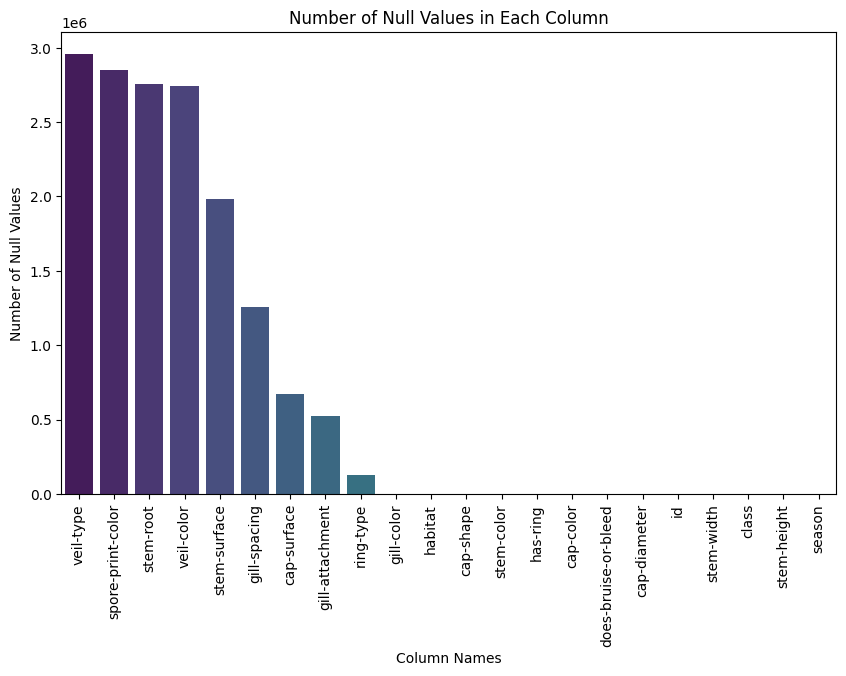

In [7]:
null_counts = train_df.isnull().sum()
null_counts = null_counts.sort_values(ascending=False)

print(null_counts)

plt.figure(figsize=(10, 6))
sns.barplot(x=null_counts.index, y=null_counts.values, palette='viridis')

plt.title('Number of Null Values in Each Column')
plt.xlabel('Column Names')
plt.ylabel('Number of Null Values')
plt.xticks(rotation=90)

plt.show()

In [8]:
duplicate_count = train_df.duplicated().sum()

print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


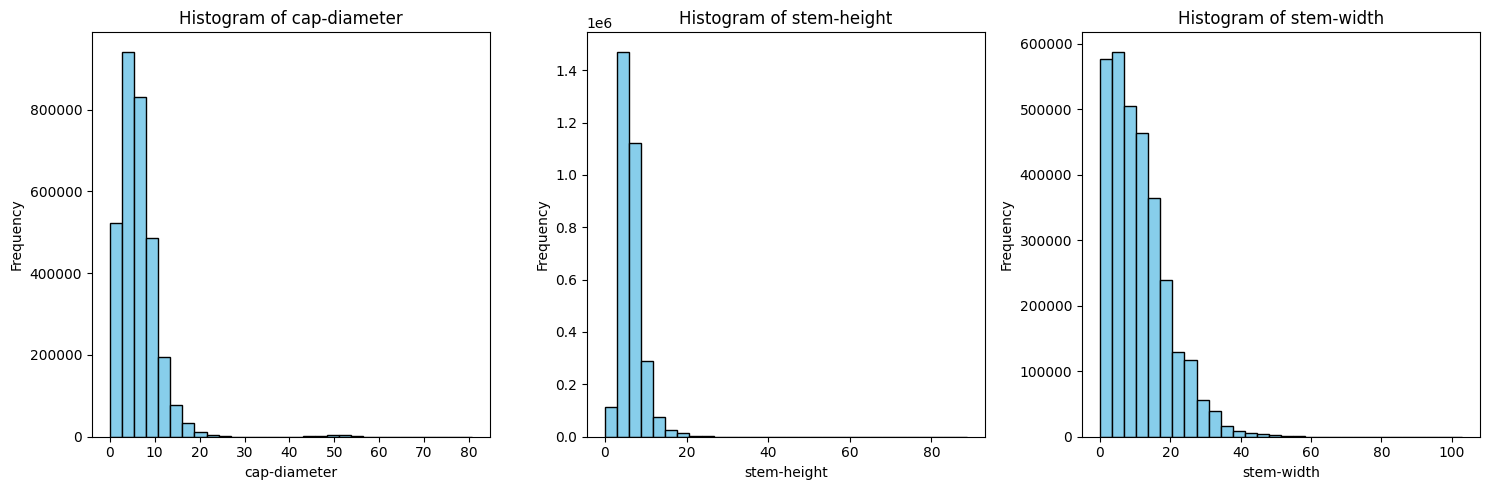

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for i, col in enumerate(train_df.select_dtypes(include=['float64']).columns):
    axes[i].hist(train_df[col], bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 2.3 First Thoughts
* We have a **ton** of training data. Good news for us, we will be able to split this into a train, dev, test set. 
* There are a lot of data artifacts in the set. In the next section, we will define .1% as the cutoff for artifacts that will get reassigned to another value. 
* Null values will also have to be handled. 
* No duplicates, that's a good sign. 

# 3. Data Cleaning
## 3.1 Replacing Null and Artifacts
Now that we have a good sense of what data we are working with, let's get it ready for a model. First, let's handle those data artifacts by writing a function to rewrite those smaller values and any null values we might have. Intuitively we know already that we are probably going to be using a Deep Neural Network (DNN) for this problem. 

In [10]:
for col in train_df.select_dtypes(include=['float64']).columns:
    train_df[col] = train_df[col].fillna(0)


In [11]:
def rewrite_values(df, threshold=0.1):
    for column in df.columns:
        if df[column].dtype == 'object':
            total_count = df[column].notna().sum()
            value_counts = df[column].value_counts()
            replace_dict = {value: 'not' if count / total_count < (threshold / 100) else value
                            for value, count in value_counts.items()}
            df[column] = df[column].map(replace_dict).fillna('null')

rewrite_values(train_df)

In [12]:
unique_counts = {}

for column in train_df.columns:
    unique_counts[column] = train_df[column].nunique()

unique_counts_series = pd.Series(unique_counts)

print(unique_counts_series)

id                      3116945
class                         2
cap-diameter               3914
cap-shape                     9
cap-surface                  13
cap-color                    14
does-bruise-or-bleed          4
gill-attachment               9
gill-spacing                  5
gill-color                   14
stem-height                2749
stem-width                 5836
stem-root                     7
stem-surface                  9
stem-color                   14
veil-type                     3
veil-color                    8
has-ring                      4
ring-type                    10
spore-print-color             9
habitat                      10
season                        4
dtype: int64


## 3.2 Prepare Data for Model

In [13]:
scaler = MinMaxScaler()

df_encoded = pd.get_dummies(train_df, columns=train_df.select_dtypes(include=['object']).columns, dtype=int)
continuous_cols = df_encoded.select_dtypes(include=['float64']).columns
df_encoded[continuous_cols] = scaler.fit_transform(df_encoded[continuous_cols])

df_encoded = df_encoded.drop(['id'], axis=1)

pd.set_option('display.max_columns', None)
df_encoded.head()

,cap-diameter,stem-height,stem-width,class_e,class_p,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_not,cap-shape_null,cap-shape_o,cap-shape_p,cap-shape_s,cap-shape_x,cap-surface_d,cap-surface_e,cap-surface_g,cap-surface_h,cap-surface_i,cap-surface_k,cap-surface_l,cap-surface_not,cap-surface_null,cap-surface_s,cap-surface_t,cap-surface_w,cap-surface_y,cap-color_b,cap-color_e,cap-color_g,cap-color_k,cap-color_l,cap-color_n,cap-color_not,cap-color_null,cap-color_o,cap-color_p,cap-color_r,cap-color_u,cap-color_w,cap-color_y,does-bruise-or-bleed_f,does-bruise-or-bleed_not,does-bruise-or-bleed_null,does-bruise-or-bleed_t,gill-attachment_a,gill-attachment_d,gill-attachment_e,gill-attachment_f,gill-attachment_not,gill-attachment_null,gill-attachment_p,gill-attachment_s,gill-attachment_x,gill-spacing_c,gill-spacing_d,gill-spacing_f,gill-spacing_not,gill-spacing_null,gill-color_b,gill-color_e,gill-color_f,gill-color_g,gill-color_k,gill-color_n,gill-color_not,gill-color_null,gill-color_o,gill-color_p,gill-color_r,gill-color_u,gill-color_w,gill-color_y,stem-root_b,stem-root_c,stem-root_f,stem-root_not,stem-root_null,stem-root_r,stem-root_s,stem-surface_g,stem-surface_h,stem-surface_i,stem-surface_k,stem-surface_not,stem-surface_null,stem-surface_s,stem-surface_t,stem-surface_y,stem-color_b,stem-color_e,stem-color_g,stem-color_k,stem-color_l,stem-color_n,stem-color_not,stem-color_null,stem-color_o,stem-color_p,stem-color_r,stem-color_u,stem-color_w,stem-color_y,veil-type_not,veil-type_null,veil-type_u,veil-color_e,veil-color_k,veil-color_n,veil-color_not,veil-color_null,veil-color_u,veil-color_w,veil-color_y,has-ring_f,has-ring_not,has-ring_null,has-ring_t,ring-type_e,ring-type_f,ring-type_g,ring-type_l,ring-type_m,ring-type_not,ring-type_null,ring-type_p,ring-type_r,ring-type_z,spore-print-color_g,spore-print-color_k,spore-print-color_n,spore-print-color_not,spore-print-color_null,spore-print-color_p,spore-print-color_r,spore-print-color_u,spore-print-color_w,habitat_d,habitat_g,habitat_h,habitat_l,habitat_m,habitat_not,habitat_null,habitat_p,habitat_u,habitat_w,season_a,season_s,season_u,season_w
0,0.109086,0.050834,0.149563,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0.055907,0.053990,0.062974,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0.086030,0.077209,0.096501,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3,0.048097,0.046889,0.063460,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0.072518,0.037985,0.081244,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0


## 3.3 Creating our Train and Dev Sets
We are going to choose a 90%, 10% split for our train and dev sets. 

In [14]:
df_encoded_x = df_encoded.drop(columns=['class_e', 'class_p'])
df_encoded_y = df_encoded['class_e']

In [15]:
train_data_x, temp_data_x, train_data_y, temp_data_y = train_test_split(df_encoded_x, df_encoded_y, test_size=0.02, random_state=16)
dev_data_x, test_data_x, dev_data_y, test_data_y = train_test_split(temp_data_x, temp_data_y, test_size=.5, random_state=16)

print(f"Train set size: {len(train_data_x)} rows")
print(f"Dev set size: {len(dev_data_x)} rows")
print(f"Test set size: {len(test_data_x)} rows")

Train set size: 3054606 rows
Dev set size: 31169 rows
Test set size: 31170 rows


# 4 Initial Model Testing
## 4.1 Define a custom MCC metric function

In [16]:
def mcc(y_true, y_pred):
    y_pred_pos = tf.round(tf.clip_by_value(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_true_pos = tf.round(tf.clip_by_value(y_true, 0, 1))
    y_true_neg = 1 - y_true_pos

    y_pred_pos = tf.cast(y_pred_pos, tf.float32)
    y_pred_neg = tf.cast(y_pred_neg, tf.float32)
    y_true_pos = tf.cast(y_true_pos, tf.float32)
    y_true_neg = tf.cast(y_true_neg, tf.float32)

    tp = tf.reduce_sum(y_true_pos * y_pred_pos)
    tn = tf.reduce_sum(y_true_neg * y_pred_neg)
    fp = tf.reduce_sum(y_true_neg * y_pred_pos)
    fn = tf.reduce_sum(y_true_pos * y_pred_neg)

    numerator = (tp * tn) - (fp * fn)
    denominator = tf.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    mcc = tf.where(tf.math.equal(denominator, 0), 0.0, numerator / denominator)
    return mcc

## 4.2 Define a DNN

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(train_data_x.shape[1],)),  # Explicit Input layer
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[mcc])

In [18]:
DNN = model.fit(train_data_x, train_data_y, epochs=5, batch_size=512, validation_data = (dev_data_x, dev_data_y))


Epoch 1/5
5967/5967 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 0.0794 - mcc: 0.9479 - val_loss: 0.0394 - val_mcc: 0.9825
Epoch 2/5
5967/5967 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 0.0415 - mcc: 0.9817 - val_loss: 0.0390 - val_mcc: 0.9825
Epoch 3/5
5967/5967 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 0.0407 - mcc: 0.9821 - val_loss: 0.0381 - val_mcc: 0.9833
Epoch 4/5
5967/5967 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 0.0399 - mcc: 0.9825 - val_loss: 0.0370 - val_mcc: 0.9840
Epoch 5/5
5967/5967 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 0.0395 - mcc: 0.9828 - val_loss: 0.0390 - val_mcc: 0.9834


# 5 Initial Model Validation
## 5.1 Loss

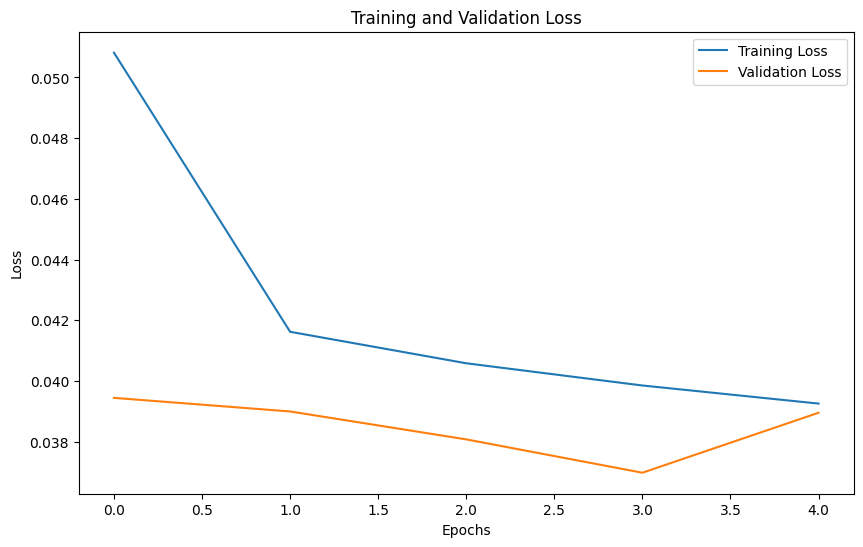

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(DNN.history['loss'], label='Training Loss')
plt.plot(DNN.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 5.2 MCC Metric

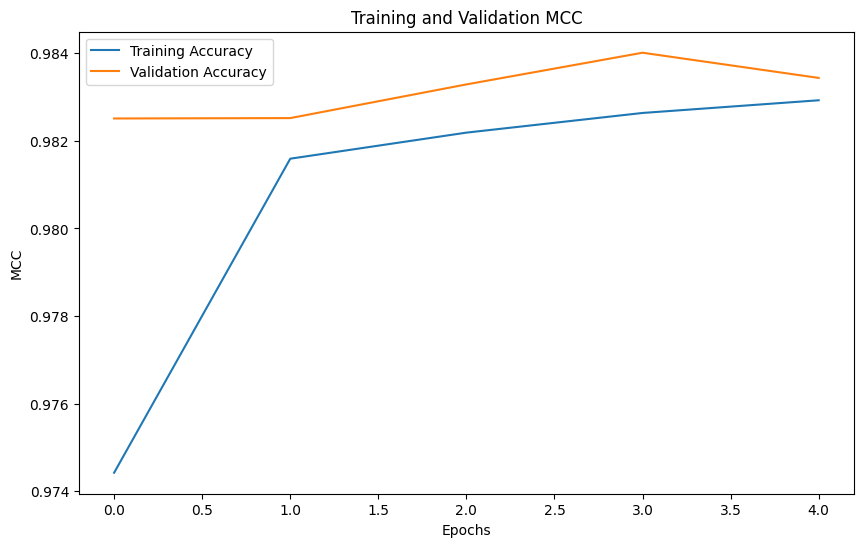

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(DNN.history['mcc'], label='Training Accuracy')
plt.plot(DNN.history['val_mcc'], label='Validation Accuracy')
plt.title('Training and Validation MCC')
plt.xlabel('Epochs')
plt.ylabel('MCC')
plt.legend()
plt.show()

## 5.3 Test Data Set

In [21]:
test_loss, test_metrics = model.evaluate(test_data_x, test_data_y)

print(f"Test Loss: {test_loss}")
print(f"Test Metrics: {test_metrics}")

975/975 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0391 - mcc: 0.9834
Test Loss: 0.04167410358786583
Test Metrics: 0.9811306595802307
